🏡 我的环境：

+ 语言环境：Python3.8
+ 编译器：jupyter notebook
+ 深度学习环境：Pytorch

# 一、 前期准备

## 1. 设置GPU

如果设备上支持GPU就使用GPU,否则使用CPU

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

## 2. 导入数据

使用dataset下载MNIST数据集，并划分好训练集与测试集

使用dataloader加载数据，并设置好基本的batch_size

⭐ **`torchvision.datasets.MNIST详解`** 

`torchvision.datasets`是Pytorch自带的一个数据库，我们可以通过代码在线下载数据，这里使用的是`torchvision.datasets`中的`MNIST`数据集。

**函数原型：**
```python
torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=False)
```
**参数说明：**
- **root** (string) ：数据地址
- **train** (string) ：`True` = 训练集，`False` = 测试集 
- **download** (bool,optional) : 如果为`True`，从互联网上下载数据集，并把数据集放在root目录下。
- **transform** (callable, optional )：这里的参数选择一个你想要的数据转化函数，直接完成数据转化
- **target_transform** (callable,optional) ：接受目标并对其进行转换的函数/转换。

In [2]:
train_ds = torchvision.datasets.MNIST('data', 
                                      train=True, 
                                      transform=torchvision.transforms.ToTensor(), # 将数据类型转化为Tensor
                                      download=True)

test_ds  = torchvision.datasets.MNIST('data', 
                                      train=False, 
                                      transform=torchvision.transforms.ToTensor(), # 将数据类型转化为Tensor
                                      download=True)

📌请在这里补充关于`torch.utils.data.DataLoader`的介绍（建议参照`torchvision.datasets.MNIST`详解）

In [3]:
batch_size = 32

train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True)

test_dl  = torch.utils.data.DataLoader(test_ds, 
                                       batch_size=batch_size)

In [4]:
# 取一个批次查看数据格式
# 数据的shape为：[batch_size, channel, height, weight]
# 其中batch_size为自己设定，channel，height和weight分别是图片的通道数，高度和宽度。
imgs, labels = next(iter(train_dl))
imgs.shape

torch.Size([32, 1, 28, 28])

## 3. 数据可视化

`squeeze()`函数的功能是从矩阵shape中，去掉维度为1的。例如一个矩阵是的shape是（5, 1），使用过这个函数后，结果为（5, ）。

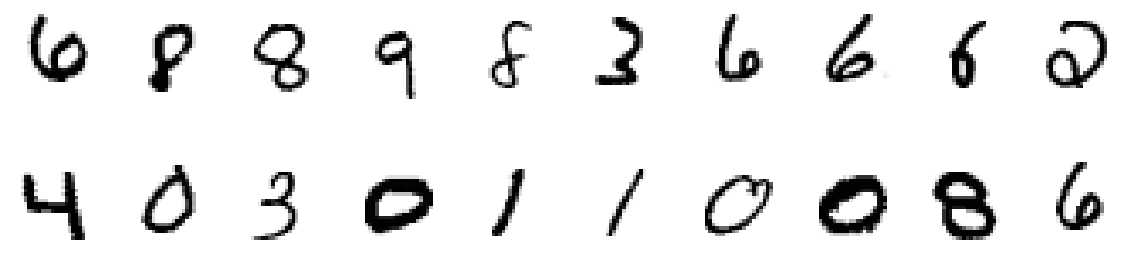

In [5]:
import numpy as np

 # 指定图片大小，图像大小为20宽、5高的绘图(单位为英寸inch)
plt.figure(figsize=(20, 5)) 
for i, imgs in enumerate(imgs[:20]):
    # 维度缩减
    npimg = np.squeeze(imgs.numpy())
    # 将整个figure分成2行10列，绘制第i+1个子图。
    plt.subplot(2, 10, i+1)
    plt.imshow(npimg, cmap=plt.cm.binary)
    plt.axis('off')

# 二、构建简单的CNN网络

 对于一般的CNN网络来说，都是由特征提取网络和分类网络构成，其中特征提取网络用于提取图片的特征，分类网络用于将图片进行分类。

nn.Conv2d为[卷积层](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)，用于提取图片的特征，传入参数为输入channel，输出channel，池化核大小

nn.MaxPool2d为[池化层](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)，进行下采样，用更高层的抽象表示图像特征，传入参数为池化核大小

nn.ReLU为[激活函数](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU)，使模型可以拟合非线性数据

nn.Linear为[全连接层](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)，可以起到特征提取器的作用，最后一层的全连接层也可以认为是输出层，传入参数为输入特征数和输出特征数（输入特征数由特征提取网络计算得到，如果不会计算可以直接运行网络，报错中会提示输入特征数的大小，下方网络中第一个全连接层的输入特征数为1600）

nn.Sequential可以[按构造顺序连接网络](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html?highlight=sequential#torch.nn.Sequential)，在初始化阶段就设定好网络结构，不需要在前向传播中重新写一遍

In [6]:
import torch.nn.functional as F

num_classes = 10  # 图片的类别数

class Model(nn.Module):
     def __init__(self):
        super().__init__()
         # 特征提取网络
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # 第一层卷积,卷积核大小为3*3
        self.pool1 = nn.MaxPool2d(2)                  # 设置池化层，池化核大小为2*2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3) # 第二层卷积,卷积核大小为3*3   
        self.pool2 = nn.MaxPool2d(2) 
                                      
        # 分类网络
        self.fc1 = nn.Linear(1600, 64)          
        self.fc2 = nn.Linear(64, num_classes)
     # 前向传播
     def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))     
        x = self.pool2(F.relu(self.conv2(x)))

        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
       
        return x

加载并打印模型

In [7]:
from torchinfo import summary
# 将模型转移到GPU中（我们模型运行均在GPU中进行）
model = Model().to(device)

summary(model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Conv2d: 1-1                            320
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            102,464
├─Linear: 1-6                            650
Total params: 121,930
Trainable params: 121,930
Non-trainable params: 0

# 三、 训练模型

## 1. 设置超参数

In [8]:
loss_fn    = nn.CrossEntropyLoss() # 创建损失函数
learn_rate = 1e-2 # 学习率
opt        = torch.optim.SGD(model.parameters(),lr=learn_rate)

## 2. 编写训练函数


**1. optimizer.zero_grad()**

函数会遍历模型的所有参数，通过内置方法截断反向传播的梯度流，再将每个参数的梯度值设为0，即上一次的梯度记录被清空。

**2. loss.backward()**

PyTorch的反向传播(即`tensor.backward()`)是通过autograd包来实现的，autograd包会根据tensor进行过的数学运算来自动计算其对应的梯度。

具体来说，torch.tensor是autograd包的基础类，如果你设置tensor的requires_grads为True，就会开始跟踪这个tensor上面的所有运算，如果你做完运算后使用`tensor.backward()`，所有的梯度就会自动运算，tensor的梯度将会累加到它的.grad属性里面去。

更具体地说，损失函数loss是由模型的所有权重w经过一系列运算得到的，若某个w的requires_grads为True，则w的所有上层参数（后面层的权重w）的.grad_fn属性中就保存了对应的运算，然后在使用`loss.backward()`后，会一层层的反向传播计算每个w的梯度值，并保存到该w的.grad属性中。

如果没有进行`tensor.backward()`的话，梯度值将会是None，因此`loss.backward()`要写在`optimizer.step()`之前。

**3. optimizer.step()**

step()函数的作用是执行一次优化步骤，通过梯度下降法来更新参数的值。因为梯度下降是基于梯度的，所以在执行`optimizer.step()`函数前应先执行`loss.backward()`函数来计算梯度。

注意：optimizer只负责通过梯度下降进行优化，而不负责产生梯度，梯度是`tensor.backward()`方法产生的。

In [9]:
# 训练循环
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)  # 训练集的大小，一共60000张图片
    num_batches = len(dataloader)   # 批次数目，1875（60000/32）

    train_loss, train_acc = 0, 0  # 初始化训练损失和正确率
    
    for X, y in dataloader:  # 获取图片及其标签
        X, y = X.to(device), y.to(device)
        
        # 计算预测误差
        pred = model(X)          # 网络输出
        loss = loss_fn(pred, y)  # 计算网络输出和真实值之间的差距，targets为真实值，计算二者差值即为损失
        
        # 反向传播
        optimizer.zero_grad()  # grad属性归零
        loss.backward()        # 反向传播
        optimizer.step()       # 每一步自动更新
        
        # 记录acc与loss
        train_acc  += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()
            
    train_acc  /= size
    train_loss /= num_batches

    return train_acc, train_loss

## 3. 编写测试函数

测试函数和训练函数大致相同，但是由于不进行梯度下降对网络权重进行更新，所以不需要传入优化器

In [10]:
def test(dataloader, model, loss_fn):
    size        = len(dataloader.dataset)  # 测试集的大小，一共10000张图片
    num_batches = len(dataloader)          # 批次数目，313（10000/32=312.5，向上取整）
    
    test_loss, test_acc = 0, 0
    
    # 当不进行训练时，停止梯度更新，节省计算内存消耗
    with torch.no_grad():
        for imgs, target in dataloader:
            imgs, target = imgs.to(device), target.to(device)
            
            # 计算loss
            target_pred = model(imgs)
            loss        = loss_fn(target_pred, target)
            
            test_loss += loss.item()
            test_acc  += (target_pred.argmax(1) == target).type(torch.float).sum().item()

    test_acc  /= size
    test_loss /= num_batches

    return test_acc, test_loss

## 4. 正式训练

**1. model.train()**

`model.train()`的作用是启用 Batch Normalization 和 Dropout。

如果模型中有`BN`层(Batch Normalization）和`Dropout`，需要在训练时添加`model.train()`。`model.train()`是保证BN层能够用到每一批数据的均值和方差。对于`Dropout`，`model.train()`是随机取一部分网络连接来训练更新参数。

**2. model.eval()**

`model.eval()`的作用是不启用 Batch Normalization 和 Dropout。

如果模型中有BN层(Batch Normalization）和Dropout，在测试时添加`model.eval()`。`model.eval()`是保证BN层能够用全部训练数据的均值和方差，即测试过程中要保证BN层的均值和方差不变。对于`Dropout`，`model.eval()`是利用到了所有网络连接，即不进行随机舍弃神经元。

训练完train样本后，生成的模型model要用来测试样本。在`model(test)`之前，需要加上`model.eval()`，否则的话，有输入数据，即使不训练，它也会改变权值。这是model中含有BN层和Dropout所带来的的性质。

In [11]:
epochs     = 5
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

for epoch in range(epochs):
    model.train()
    epoch_train_acc, epoch_train_loss = train(train_dl, model, loss_fn, opt)
    
    model.eval()
    epoch_test_acc, epoch_test_loss = test(test_dl, model, loss_fn)
    
    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    
    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%，Test_loss:{:.3f}')
    print(template.format(epoch+1, epoch_train_acc*100, epoch_train_loss, epoch_test_acc*100, epoch_test_loss))
print('Done')

Epoch: 1, Train_acc:81.2%, Train_loss:0.651, Test_acc:93.6%，Test_loss:0.219
Epoch: 2, Train_acc:94.6%, Train_loss:0.182, Test_acc:96.1%，Test_loss:0.130
Epoch: 3, Train_acc:96.5%, Train_loss:0.117, Test_acc:97.3%，Test_loss:0.092
Epoch: 4, Train_acc:97.2%, Train_loss:0.091, Test_acc:97.8%，Test_loss:0.070
Epoch: 5, Train_acc:97.7%, Train_loss:0.076, Test_acc:98.3%，Test_loss:0.058
Done


# 四、 结果可视化

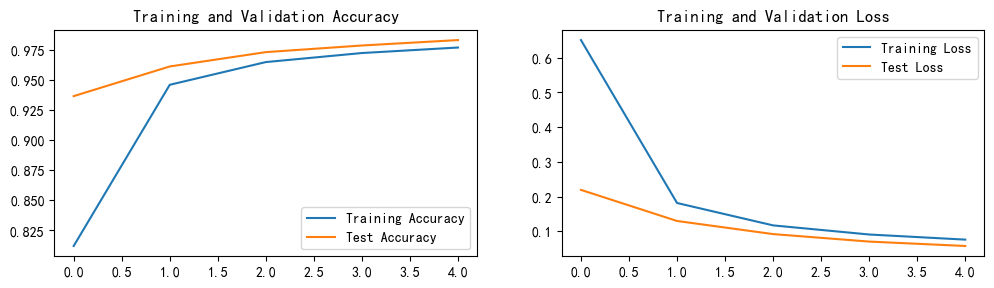

In [12]:
import matplotlib.pyplot as plt
#隐藏警告
import warnings
warnings.filterwarnings("ignore")               #忽略警告信息
plt.rcParams['font.sans-serif']    = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False      # 用来正常显示负号
plt.rcParams['figure.dpi']         = 100        #分辨率

epochs_range = range(epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()